In [13]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [14]:
# File paths
input_file = "../data/Almond disease survey data ALL.csv"
output_file = "../data/HR_processed_data.csv"

In [15]:
# aggregate year, orchard and variety to calculate HR incidence

def preprocess_almond_data(file_path, output_path):
    # Load dataset
    df = pd.read_csv(file_path)
    
    # Trim column names to remove extra spaces
    df.columns = df.columns.str.strip()
    
    df = df[(df["Variety"] != "Unknown")]

    # Standardize categorical values (ensure consistent case formatting)
    df["Orchard"] = df["Orchard"].str.strip().str.title()
    df["Variety"] = df["Variety"].str.strip().str.title()
    df["Hull split"] = df["Hull split"].str.strip()

    # Ensure Year is treated as a categorical variable for filtering later
    df["Year"] = df["Year"].astype(str).str.strip()

    columns_to_drop = [
    'Row', 'Tree', 'Tree#', 'Row spacing', 'Tree spacing', "Region Wt",	"Block",	
    "Area ha",	"TotalOrchard Area", 'Orchard wt', 'Orchard_Scale',	'RegionTotal Ha',
    'HullRot_WTD',	'HullRotJOhull', 'LLDB dead branches', 'LLDBYellowing', 'LLDB combo', 
    'Gumtrunk', 'Gumscaffold', 'Gumtree crotch', 'Trunkcankers', 'Twig canker', 'Foamy canker', 
    'TD combo', 'Wilting - whole tree decline', 'Wilting - one scaffold', 'Wiltcombo',
    'Anthracnose - nut', 'Anthracnose - leaf', 'Anthracnose combo',
    'Bacterial spot - nut', 'Bacterial spot - leaf', 'Bacterial spot combo',
    'Scab - nut', 'Scab - leaf', 'Scab combo', 'Rust', 'Shot Hole - nut',
    'Shot Hole - leaf', 'Shotholecombo', 'Alternaria leaf spot',
    'Unknown leaf spot/ symptom', 'Unknown fruit spot/ symptom', 'Unknown fruit gum'
    ]

    df = df.drop(columns=columns_to_drop)

    # Define relevant columns for weather data aggregation
    weather_columns = [
        "Days over 40C", "Days over 35C", "Total Amount of rain ml since 1 Jan",
        "No of rain days since 1 Jan", 'Days since last rain <5days from assess', 
        'Amt rain in last event<5days from assess', 'Days since last rain >5days from assess', 
        'Amt rain in last event>5days from assess', 'Total rain Jan mm', 'No rain days Jan', 
        'Total rain Feb mm', 'No rain days Feb', 'Rain 1st week Jan', 'Rain 2nd week  Jan', 'Rain 3rd week  Jan', 
        'Rain 4th week  Jan', 'Rain within 7 days of assessment', 'Rain within 10 days of assessment'
    ]

    hull_rot_columns = ["HR comboF"]

    # Keep State and Region columns
    meta_columns = ["State", "Region"]

    # Aggregate weather again after filtering
    weather_data = df.groupby(["Year", "Orchard", "Variety"])[weather_columns].first().reset_index()

    # Get State and Region from first observation per group
    region_data = df.groupby(["Year", "Orchard", "Variety"])[meta_columns].first().reset_index()

    # Recompute tree counts and HR incidence after filtering
    tree_counts = df.groupby(["Orchard", "Variety", "Year"]).size().reset_index(name="Total_Trees_Assessed")
    hull_rot_proportion = df.groupby(["Orchard", "Variety", "Year"])[hull_rot_columns].sum().reset_index()

    # Calculate HR Incidence
    hull_rot_proportion["HR Incidence"] = hull_rot_proportion["HR comboF"] / tree_counts["Total_Trees_Assessed"]

    # Final merged summary dataset (one row per Year, Orchard, Variety)
    final_df = (
        weather_data
        .merge(region_data, on=["Year", "Orchard", "Variety"], how="left")
        .merge(tree_counts, on=["Orchard", "Variety", "Year"], how="left")
        .merge(hull_rot_proportion[["Orchard", "Variety", "Year", "HR Incidence"]], on=["Orchard", "Variety", "Year"], how="left")
    )

    # Reorder columns to show State and Region next to Orchard
    cols = final_df.columns.tolist()
    if "State" in cols and "Region" in cols:
        cols.remove("State")
        cols.remove("Region")
        orchard_index = cols.index("Orchard")
        cols = cols[:orchard_index + 1] + ["State", "Region"] + cols[orchard_index + 1:]
        final_df = final_df[cols]

    # Save processed data
    final_df.to_csv(output_path, index=False)
    print(f"Processed data saved to {output_path}")
    print(final_df)

# Example usage

preprocess_almond_data(input_file, output_file)

Processed data saved to ../data/HR_processed_data.csv
        Year    Orchard State     Region       Variety  Days over 40C  \
0    2018.19  Belvedere   Vic   Riverina        Carmel           16.0   
1    2018.19  Belvedere   Vic   Riverina      Monterey           16.0   
2    2018.19  Belvedere   Vic   Riverina            Np           16.0   
3    2018.19  Belvedere   Vic   Riverina         Price           16.0   
4    2018.19    Bennett   Vic  Sunraysia        Carmel            8.0   
..       ...        ...   ...        ...           ...            ...   
197   2019.2      Wemen   Vic  Sunraysia         Price            2.0   
198   2019.2     Yilgah   NSW   Riverina        Carmel            6.0   
199   2019.2     Yilgah   NSW   Riverina  Independence            6.0   
200   2019.2     Yilgah   NSW   Riverina            Np            6.0   
201   2019.2     Yilgah   NSW   Riverina         Price            6.0   

     Days over 35C  Total Amount of rain ml since 1 Jan  \
0         

In [16]:
# Load your processed dataset
df = pd.read_csv("../data/HR_processed_data.csv")

# Step 1: Check missing value count and percentage
missing_summary = df.isnull().sum().to_frame(name="MissingCount")
missing_summary["MissingPercent"] = (missing_summary["MissingCount"] / len(df)) * 100
print("🔍 Missing Value Summary:")
print(missing_summary)

# Step 2: Drop columns with more than 30% missing data
threshold = 30  # percent
cols_to_drop = missing_summary[missing_summary["MissingPercent"] > threshold].index.tolist()
df_cleaned = df.drop(columns=cols_to_drop)

print(f"\n✅ Dropped columns with >{threshold}% missing data: {cols_to_drop}")

# Step 3: Impute remaining missing numerical values with median
numeric_cols = df_cleaned.select_dtypes(include=["float64", "int64"]).columns
df_cleaned[numeric_cols] = df_cleaned[numeric_cols].fillna(df_cleaned[numeric_cols].median())

# Optional: Save cleaned dataset
df_cleaned.to_csv("../data/HR_processed_cleaned.csv", index=False)
print("\n✅ Cleaned dataset saved to 'HR_processed_cleaned.csv'")


🔍 Missing Value Summary:
                                          MissingCount  MissingPercent
Year                                                 0        0.000000
Orchard                                              0        0.000000
State                                                0        0.000000
Region                                               0        0.000000
Variety                                              0        0.000000
Days over 40C                                        3        1.485149
Days over 35C                                        3        1.485149
Total Amount of rain ml since 1 Jan                  3        1.485149
No of rain days since 1 Jan                          3        1.485149
Days since last rain <5days from assess             59       29.207921
Amt rain in last event<5days from assess             3        1.485149
Days since last rain >5days from assess              3        1.485149
Amt rain in last event>5days from assess            


🔍 Top Correlated Features with HR Incidence:
No rain days Feb                            0.426135
Amt rain in last event>5days from assess    0.397069
Total Amount of rain ml since 1 Jan         0.346881
Total rain Feb mm                           0.339314
Rain within 10 days of assessment           0.337430
No of rain days since 1 Jan                 0.329035
Rain 3rd week  Jan                          0.328988
Total rain Jan mm                           0.286952
Rain within 7 days of assessment            0.280354
Amt rain in last event<5days from assess    0.279938
No rain days Jan                            0.166714
Days over 35C                               0.139330
Total_Trees_Assessed                        0.132922
Days over 40C                               0.083681
Rain 2nd week  Jan                          0.074317
Year                                        0.067883
Rain 4th week  Jan                         -0.005920
Rain 1st week Jan                          -0.095100


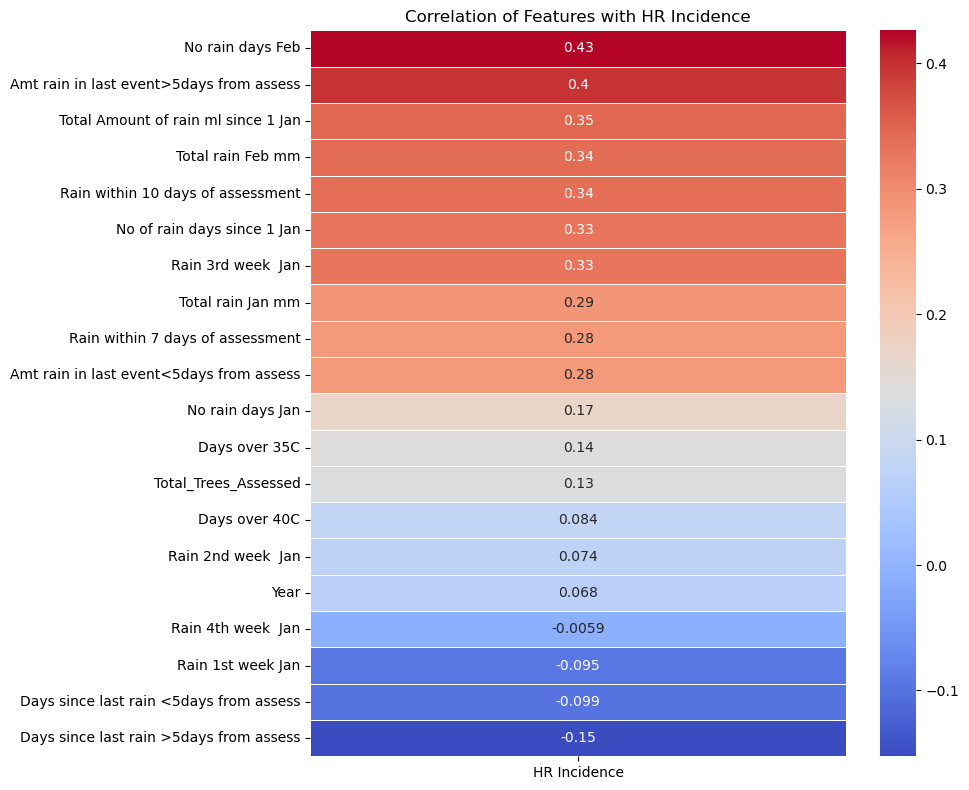

In [17]:
# Step 3: Correlation matrix
corr_matrix = df_cleaned.corr(numeric_only=True)

# Focus only on correlation with HR Incidence
hr_corr = corr_matrix["HR Incidence"].drop("HR Incidence").sort_values(ascending=False)

# Print correlation values
print("\n🔍 Top Correlated Features with HR Incidence:")
print(hr_corr)

# Step 4: Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(hr_corr.to_frame(), annot=True, cmap="coolwarm", linewidths=0.5, cbar=True)
plt.title("Correlation of Features with HR Incidence")
plt.tight_layout()
plt.show()